# Simaese Model Architecture Implementation Proof of Concept

This notebook (and the accompanying files: train_mnist.py, model_2_mnist.py) are a responce to my initial attempts of training the first model iteration of the signature verification model. Which is a siamese network. The model was severely underfitting the data with no convergence at all during training. I had many initial speculations as to why this was. I attempted to adress those speculations, but quickly realized that there were too many considerations to acccurate test how well my changes were being implemented. I also began to realize that my initial implementation of both the model and data preperation pipeline contained numerous convoluded steps.

This notebook and the other files in the dir are my redesign of the model architecure and training process for the signature verification task. To save compute, I am using MNIST instead of the signature dataset. 

### The Key Goals fo this Notetbook are to:
- Gain insight into possible errors in my original signature data implemplmentaion. 
- Simplify the model and training process for both readability and computational complexity
- Achieve Some Convergence in the training process, but it is not necessary to optimize fully for the MNIST dataset.

### Result:
The above goals were achieved. There are more thourough descriptions of what specific changes were made to the model and training script in model_2_mnist.py and train_mnist.py respectively.


### Here I am going to load in the dataset 

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)


### Load in Model

This is the adjusted model for the mnist

In [2]:
from model_2_mnist import SiameseNet 

model = SiameseNet()

Below I am running a forward pass on a single example

In [3]:
# get image from trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)


# get two images from the batch
image1 = images[0].unsqueeze(0) # unsqueeze to add a batch dimension
image2 = images[1].unsqueeze(0) # unsqueeze to add a batch dimension

# get the output of the model
output = model(image1, image2)

print("\nOutput shape:", output.shape)
print("\nOutput:", output)

# perform ge function with threhshold of 0.5 with the model output
prediction = torch.ge(output, 0.5)

print("\nPrediction:", prediction)


Output shape: torch.Size([1])

Output: tensor([0.6321], grad_fn=<SigmoidBackward0>)

Prediction: tensor([True])


In [4]:
# Count the number of trainable parameters
layer_params = [p.numel() for p in model.parameters() if p.requires_grad]

# print params at each layer
for i, p in enumerate(layer_params):
    print(f"Layer {i} has {p} parameters")

# sum parameters
print(f"\n Total number of trainable parameters: {sum(layer_params)}")

Layer 0 has 36 parameters
Layer 1 has 4 parameters
Layer 2 has 4 parameters
Layer 3 has 4 parameters
Layer 4 has 144 parameters
Layer 5 has 4 parameters
Layer 6 has 4 parameters
Layer 7 has 4 parameters
Layer 8 has 288 parameters
Layer 9 has 8 parameters
Layer 10 has 8 parameters
Layer 11 has 8 parameters
Layer 12 has 576 parameters
Layer 13 has 8 parameters
Layer 14 has 8 parameters
Layer 15 has 8 parameters
Layer 16 has 1152 parameters
Layer 17 has 16 parameters
Layer 18 has 16 parameters
Layer 19 has 16 parameters
Layer 20 has 2304 parameters
Layer 21 has 16 parameters
Layer 22 has 16 parameters
Layer 23 has 16 parameters
Layer 24 has 1440 parameters
Layer 25 has 10 parameters

 Total number of trainable parameters: 6118


## Load Training Environment

Here I am setting up the Trainer class form wihtin train_mnist.py

In [5]:
from train_mnist import Trainer
import torch.nn as nn

#set criterion and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#set epochs
epochs = 200

#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

#set early stopping patience
patience = 20

#set log frequency for model eval 
log_frequency = 1

# create trainer instance
trainer = Trainer( model = model,
                   criterion = criterion, 
                   optimizer = optimizer, 
                   train_loader = trainloader, 
                   val_loader = testloader, 
                   epochs = epochs, 
                   device = device, 
                   early_stopping_patience = patience, 
                   log_freq = log_frequency, 
                   batch_size=256)

Device: cuda


In [7]:
import time

print("starting training...\n\n")

start = time.time()

best_model, historical_loss, historical_acc = trainer.train()    

end = time.time()

print(f"\nTraining time: {end - start}")

starting training...


Epoch 0: Train Loss: 0.70140 -- Train Accuracy 0.520 -- Val Loss: 0.32116 -- Val Accuracy: 0.283
Epoch 1: Train Loss: 0.66774 -- Train Accuracy 0.585 -- Val Loss: 0.31418 -- Val Accuracy: 0.297
Epoch 2: Train Loss: 0.65475 -- Train Accuracy 0.618 -- Val Loss: 0.30982 -- Val Accuracy: 0.309
Epoch 3: Train Loss: 0.65231 -- Train Accuracy 0.622 -- Val Loss: 0.30690 -- Val Accuracy: 0.314
Epoch 4: Train Loss: 0.64827 -- Train Accuracy 0.639 -- Val Loss: 0.30575 -- Val Accuracy: 0.319
Epoch 5: Train Loss: 0.64531 -- Train Accuracy 0.646 -- Val Loss: 0.30519 -- Val Accuracy: 0.319
Epoch 6: Train Loss: 0.64138 -- Train Accuracy 0.655 -- Val Loss: 0.30335 -- Val Accuracy: 0.328
Epoch 7: Train Loss: 0.64065 -- Train Accuracy 0.657 -- Val Loss: 0.30259 -- Val Accuracy: 0.332
Epoch 8: Train Loss: 0.63567 -- Train Accuracy 0.674 -- Val Loss: 0.30171 -- Val Accuracy: 0.334
Epoch 9: Train Loss: 0.63443 -- Train Accuracy 0.673 -- Val Loss: 0.30131 -- Val Accuracy: 0.332
Epoch 1

Epoch 84: Train Loss: 0.61296 -- Train Accuracy 0.825 -- Val Loss: 0.29205 -- Val Accuracy: 0.408
Epoch 85: Train Loss: 0.61138 -- Train Accuracy 0.831 -- Val Loss: 0.29217 -- Val Accuracy: 0.404
Epoch 86: Train Loss: 0.61318 -- Train Accuracy 0.824 -- Val Loss: 0.29159 -- Val Accuracy: 0.408
Epoch 87: Train Loss: 0.61125 -- Train Accuracy 0.830 -- Val Loss: 0.29224 -- Val Accuracy: 0.409
Epoch 88: Train Loss: 0.61157 -- Train Accuracy 0.827 -- Val Loss: 0.29202 -- Val Accuracy: 0.410
Epoch 89: Train Loss: 0.61264 -- Train Accuracy 0.831 -- Val Loss: 0.29152 -- Val Accuracy: 0.410
Epoch 90: Train Loss: 0.61218 -- Train Accuracy 0.827 -- Val Loss: 0.29162 -- Val Accuracy: 0.414
Epoch 91: Train Loss: 0.61252 -- Train Accuracy 0.836 -- Val Loss: 0.29185 -- Val Accuracy: 0.409
Epoch 92: Train Loss: 0.61102 -- Train Accuracy 0.845 -- Val Loss: 0.29169 -- Val Accuracy: 0.414
Epoch 93: Train Loss: 0.61255 -- Train Accuracy 0.841 -- Val Loss: 0.29161 -- Val Accuracy: 0.415
Epoch 94: Train Loss

Epoch 167: Train Loss: 0.60982 -- Train Accuracy 0.894 -- Val Loss: 0.29063 -- Val Accuracy: 0.437
Epoch 168: Train Loss: 0.60892 -- Train Accuracy 0.882 -- Val Loss: 0.29117 -- Val Accuracy: 0.429
Epoch 169: Train Loss: 0.60956 -- Train Accuracy 0.882 -- Val Loss: 0.29082 -- Val Accuracy: 0.434
Epoch 170: Train Loss: 0.60928 -- Train Accuracy 0.890 -- Val Loss: 0.29076 -- Val Accuracy: 0.434
Epoch 171: Train Loss: 0.61024 -- Train Accuracy 0.894 -- Val Loss: 0.29078 -- Val Accuracy: 0.437
Epoch 172: Train Loss: 0.60976 -- Train Accuracy 0.888 -- Val Loss: 0.29109 -- Val Accuracy: 0.436
Epoch 173: Train Loss: 0.60851 -- Train Accuracy 0.896 -- Val Loss: 0.29102 -- Val Accuracy: 0.432
Epoch 174: Train Loss: 0.60837 -- Train Accuracy 0.896 -- Val Loss: 0.29078 -- Val Accuracy: 0.437
Epoch 175: Train Loss: 0.60887 -- Train Accuracy 0.900 -- Val Loss: 0.29082 -- Val Accuracy: 0.441
Epoch 176: Train Loss: 0.61013 -- Train Accuracy 0.884 -- Val Loss: 0.29085 -- Val Accuracy: 0.438
Epoch 177:

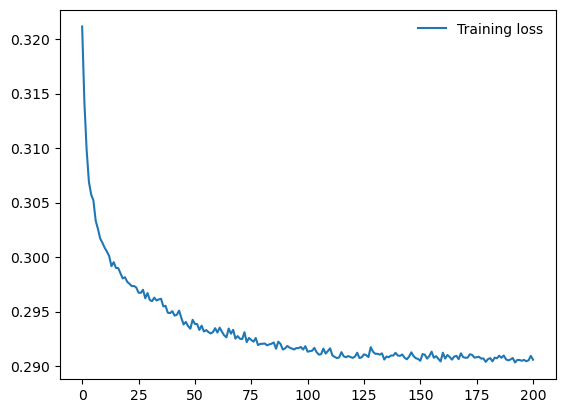

In [8]:
import matplotlib.pyplot as plt

#plot python lists historical_loss and historical_acc
plt.plot(historical_loss, label='Training loss')
plt.legend(frameon=False)


In [11]:
# Define a filepath to save the model
filepath = 'siamese_net_mnist.pth'

# Save the model’s state_dict
torch.save(best_model.state_dict(), filepath)